# Fine-tuning on Pre-trained Model for Cell-type Annotation
In this tutorial, we demonstrate how to fine-tune a pre-trained model on a new dataset for the cell type annotation task. We use the Multiple Sclerosis dataset as an example and fine-tune on the pre-trained whole-body model. Please download the dataset folder from https://drive.google.com/drive/folders/1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v?usp=sharing

We summarize the fine-tuning pipeline in the following steps, which can be used as a general recipe for finetuning on cell-type annotation tasks and beyond: 

     1. Specify hyper-parameter setup for integration task
     
     2. Load and pre-process data
     
     3. Load the pre-trained scGPT model
     
     4. Finetune scGPT with task-specific objectives
     
     5. Evaluate fine-tuned scGPT

In [1]:
# %%
import copy
import gc
import json
import os
from pathlib import Path
import shutil
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import pandas as pd
# from . import asyn
import pickle
import torch
from anndata import AnnData
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from sklearn.metrics import confusion_matrix

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(6, 6))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

Global seed set to 0
c:\Users\Alexander\Desktop\ML\scGPT\scgpt_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Alexander\Desktop\ML\scGPT\tutorials\..\scgpt\model\model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
c:\Users\Alexander\Desktop\ML\scGPT\tutorials\..\scgpt\model\multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


## Load and Format Xenium dataset

In [2]:
cells = pd.read_csv('data/cells.csv.gz')
old_cell_dens = pd.read_csv('data/cell_density_50.csv')['Value'].tolist()
nucleus_boundaries = pd.read_csv('data/nucleus_boundaries.csv.gz')
cell_boundaries = pd.read_csv('data/cell_boundaries.csv.gz')
gene_info = pd.read_csv('data/gene_info.csv')
index_column = gene_info['feature_id']
gene_names_list = gene_info['feature_name'].tolist()
transcripts = pd.read_csv('data/transcripts.csv')
filtered_transcripts = transcripts[transcripts['cell_id'] != 'UNASSIGNED']

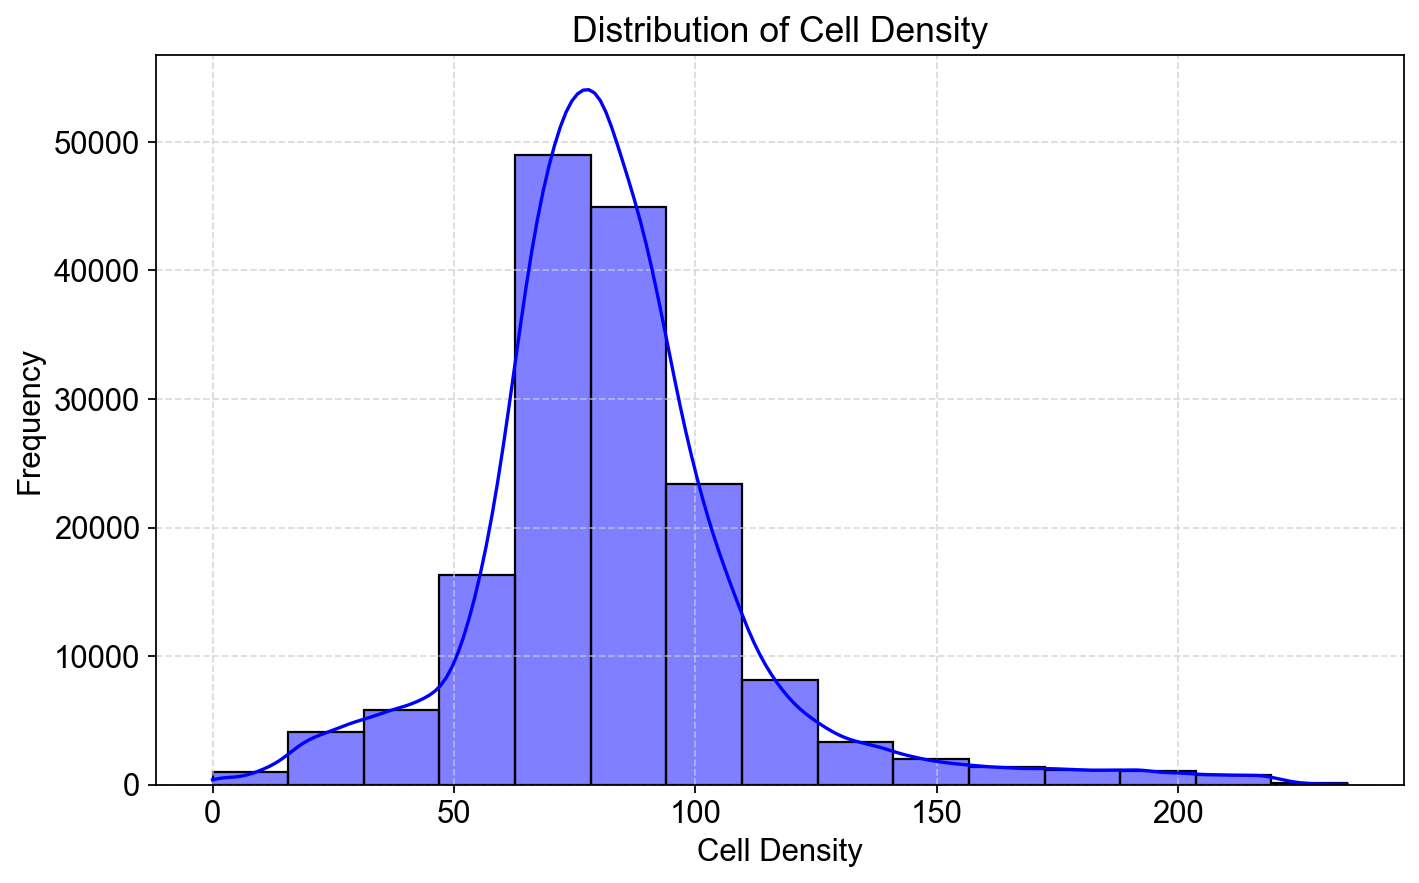

In [3]:
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(old_cell_dens, kde=True, bins=15, color='blue')
plt.title('Distribution of Cell Density', fontsize=16)
plt.xlabel('Cell Density', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [62]:

import numpy as np

def binning(cell_density, number_bins):
    """
    Assigns each cell density value to an integer bin starting from 1.

    Parameters:
    - cell_density (list or np.array): List/array of cell density values.
    - number_bins (int): Number of bins to divide the data into.

    Returns:
    - new_cell_density (np.array): Array of bin indices (1-based).
    """
    # Compute the min and max of the cell densities
    max_val = np.max(cell_density)
    min_val = np.min(cell_density)
    
    # Generate bin edges
    bins = np.linspace(min_val, max_val, number_bins + 1)  # Create number_bins intervals
    
    # Reassign cell densities to bins
    new_cell_density = np.digitize(cell_density, bins, right=False)  # Bin indices start from 1 by default

    # Ensure all values fall into valid bins (adjust if max value is included)
    new_cell_density = np.clip(new_cell_density, 1, number_bins)

    return new_cell_density


cell_dens=binning(old_cell_dens,20)

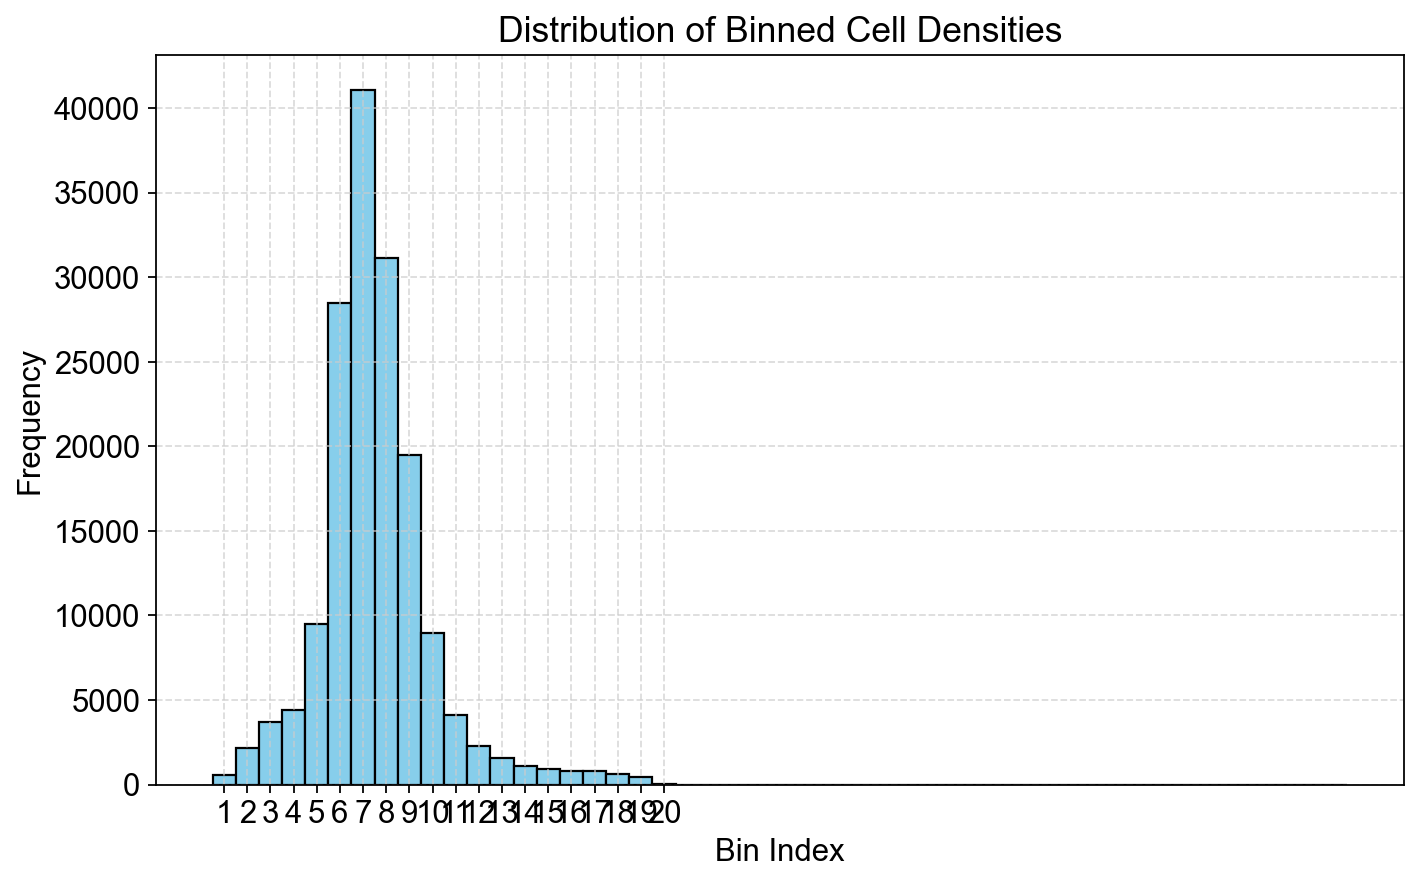

In [63]:
# Plotting the new binned cell densities
plt.figure(figsize=(10, 6))
plt.hist(cell_dens, bins=np.arange(1, 51) - 0.5, edgecolor='black', color='skyblue')
plt.title("Distribution of Binned Cell Densities", fontsize=16)
plt.xlabel("Bin Index", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(range(1, 21))  # Ensure x-ticks align with bin indices
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [64]:
# Example: Annotating cell metadata
cells_metadata = cells.set_index("cell_id")

# Example: Annotating gene metadata
gene_metadata = gene_info.set_index("feature_name")

# Load cell boundaries and group by cell_id
cell_boundaries_grouped = cell_boundaries.groupby("cell_id")[["vertex_x", "vertex_y"]].apply(lambda df: df.values.tolist())

# Load nucleus boundaries similarly
nucleus_boundaries_grouped = nucleus_boundaries.groupby("cell_id")[["vertex_x", "vertex_y"]].apply(lambda df: df.values.tolist())

# Aggregate transcript counts per cell and feature
transcript_counts = (
    filtered_transcripts.groupby(["cell_id", "feature_name"]).size().unstack(fill_value=0)
)

# Combine cells metadata with transcript counts
merged_data = cells_metadata.join(transcript_counts, how="left").fillna(0)

# Add boundaries if needed
merged_data["cell_boundaries"] = cell_boundaries_grouped
merged_data["nucleus_boundaries"] = nucleus_boundaries_grouped
#Filtering columns that are Unassigned ( and cells that have 0 transcripts )
merged_data = merged_data.loc[:, ~merged_data.columns.str.contains("UnassignedCodeword")]
merged_data = merged_data.loc[:, ~merged_data.columns.str.contains("NegControlCodeword")]
merged_data = merged_data.loc[:, ~merged_data.columns.str.contains("NegControlProbe")]

# Subtract unassigned_codeword_counts from total_counts only where unassigned_codeword_counts is non-zero
merged_data['total_counts'] -= merged_data['unassigned_codeword_counts'] * (merged_data['unassigned_codeword_counts'] != 0)

# Subtract control_codeword_counts from total_counts only where control_codeword_counts is non-zero
merged_data['total_counts'] -= merged_data['control_codeword_counts'] * (merged_data['control_codeword_counts'] != 0)

# Subtract deprecated_codeword_counts from total_counts only where control_codeword_counts is non-zero

#merged_data['total_counts'] -= merged_data['deprecated_codeword_counts'] * (merged_data['deprecated_codeword_counts'] != 0)

# Subtract control_probe_counts from total_counts only where control_codeword_counts is non-zero

merged_data['total_counts'] -= merged_data['control_probe_counts'] * (merged_data['control_probe_counts'] != 0)

merged_data.drop('control_codeword_counts', axis=1, inplace=True)

merged_data.drop('unassigned_codeword_counts', axis=1, inplace=True)

merged_data.drop('deprecated_codeword_counts', axis=1, inplace=True)

merged_data.drop('control_probe_counts', axis=1, inplace=True)

# Put the correct type for each column
"""
merged_data['cell_id'] = merged_data['cell_id'].astype('category')

merged_data['feature_name'] = merged_data['feature_name'].astype('category')
merged_data['total_counts'] = merged_data['total_counts'].astype(int)
merged_data['transcript_counts'] = merged_data['transcript_counts'].astype(int)
merged_data.iloc[:, 6:-2]=merged_data.iloc[:, 6:-2].astype(int)


merged_data['x_centroid'] = merged_data['x_centroid'].astype(float)
merged_data['y_centroid'] = merged_data['y_centroid'].astype(float)
merged_data['cell_area'] = merged_data['cell_area'].astype(float)
merged_data['nucleus_area'] = merged_data['nucleus_area'].astype(float)"""

merged_data


,x_centroid,y_centroid,transcript_counts,total_counts,cell_area,nucleus_area,ABCC11,ACE2,ACKR1,ACTA2,...,TSPAN19,UBE2C,UMOD,UPK3B,VCAN,VSIG4,VWA5A,VWF,cell_boundaries,nucleus_boundaries
cell_id,,,,,,,,,,,,,,,,,,,,,
aaaadpbp-1,206.089813,1495.898193,0,0,68.456877,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[205.0625, 1489.8375], [204.21251, 1490.4751]...",NaN
aaaaficg-1,201.765823,1816.210815,19,19,49.130002,21.268595,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[200.8125, 1811.9875], [199.5375, 1812.625], ...","[[200.175, 1813.6875], [199.32501, 1814.5376],..."
aaabbaka-1,179.024506,2167.253906,53,53,119.618911,74.778753,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[177.01251, 2158.575], [175.52501, 2159.425],...","[[177.225, 2162.4001], [176.8, 2162.6125], [17..."
aaabbjoo-1,186.060654,2163.309082,29,29,94.241097,59.109533,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[185.51251, 2156.2375], [184.2375, 2157.3], [...","[[185.9375, 2156.875], [184.875, 2157.3], [183..."
aaablchg-1,200.246887,2198.593506,42,42,120.341411,52.426408,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,"[[197.20001, 2191.9375], [197.4125, 2192.1501]...","[[197.4125, 2193.425], [197.4125, 2193.6375], ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ojaaphhh-1,4552.125977,1643.896484,3,3,26.913126,11.153594,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[4551.5376, 1640.925], [4551.325, 1641.1376],...","[[4551.5376, 1641.9875], [4551.325, 1642.2001]..."
ojabeldf-1,4437.434082,1629.141846,6,6,5.418750,5.418750,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[4437.2124, 1627.75], [4437.0, 1627.9625], [4...","[[4437.2124, 1627.75], [4437.0, 1627.9625], [4..."
ojacfbid-1,4463.312988,1576.604004,0,0,6.502500,6.502500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[4462.7124, 1575.05], [4462.2876, 1575.4751],...","[[4462.7124, 1575.05], [4462.2876, 1575.4751],..."


### Creation of Adata

In [65]:
import scipy.sparse as sp

# Define the gene expression matrix (X) as a sparse matrix
gene_expression = sp.csr_matrix(merged_data.iloc[:, 6:-2].values)

# Define the observation metadata (obs)
obs_metadata = merged_data.drop(merged_data.columns[6:-2], axis=1)

# Define variable metadata (var)
var_metadata = pd.DataFrame(index=merged_data.iloc[:, 6:-2].columns)

# Create the AnnData object
adata_spatial = AnnData(
    X=gene_expression,          # Gene expression matrix as sparse
    obs=obs_metadata,           # Cell-level metadata
    var=var_metadata            # Gene-level metadata
)
# Ensure index_column_list is a list (if not already)
index_column_list = index_column.tolist()  

# Assign the index_column_list to the 'index' column in adata_spatial.var
# Create a mapping dictionary from gene_names_list to index_column_list
gene_to_index_mapping = dict(zip(gene_names_list, index_column_list))

# Map the 'index' column in adata_spatial.var using the mapping dictionary
adata_spatial.var["index_column"] = adata_spatial.var.index.map(gene_to_index_mapping)
adata_spatial.var['gene_name'] = adata_spatial.var.index.tolist()

gene_counts = merged_data.iloc[:, 6:-2].sum(axis=0)  # Sum the gene counts across all cells
gene_names_list = adata_spatial.var.index.tolist()  # List of gene names in spatial_adata
#gene_counts_ordered = gene_counts[gene_names_list].values
adata_spatial.var['total_count'] = gene_counts.values
adata_spatial.obs['batch_id'] = np.zeros(162254)
adata_spatial.obs['celltype_id'] = cell_dens                                          # To change
adata_spatial.obs['cell_density'] = old_cell_dens                                        


# Optional: Print summary of the AnnData object
print(adata_spatial)


AnnData object with n_obs × n_vars = 162254 × 377
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area', 'cell_boundaries', 'nucleus_boundaries', 'batch_id', 'celltype_id', 'cell_density'
    var: 'index_column', 'gene_name', 'total_count'


## Step1: Specify hyper-parameter setup for cell-type annotation task
Listed below are some hyper-parameter recommendations for the cell-type task. Note that the CLS objective is on to facilitate cell-type classification.

In [66]:
hyperparameter_defaults = dict(
    seed=0,
    dataset_name="ms",
    do_train=True,
    load_model="../save/scGPT_human",
    mask_ratio=0.0,
    epochs=10,
    n_bins=21,
    MVC=False, # Masked value prediction for cell embedding
    ecs_thres=0.0, # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=0.0,
    lr=1e-3,
    batch_size=32,
    layer_size=128,
    nlayers=4,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead=4,  # number of heads in nn.MultiheadAttention
    dropout=0.2,  # dropout probability
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
    include_zero_gene = False,
    freeze = False, #freeze
    DSBN = False,  # Domain-spec batchnorm
)

In [67]:
import wandb
import torch.multiprocessing as mp

# Set the start method to 'spawn' for Windows
if mp.get_start_method() != 'spawn':
    mp.set_start_method('spawn', force=True)

# Initialize wandb with appropriate settings
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="spawn"),  # Use 'spawn' on Windows
)

config = wandb.config
print(config)

set_seed(config.seed)


epoch,▁
info/post_freeze_param_count,▁
info/pre_freeze_param_count,▁
train/cls,█▂▂▂▂▂▂▂▂▃▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▂▁▂▂▃▂▂▂▂▁▂▂▂
valid/dab,▁
valid/err,▁
valid/mse,▁
valid/sum_mse_dab,▁
epoch,1
info/post_freeze_param_count,54258741
info/pre_freeze_param_count,54258741


{'seed': 0, 'dataset_name': 'ms', 'do_train': True, 'load_model': '../save/scGPT_human', 'mask_ratio': 0.0, 'epochs': 10, 'n_bins': 21, 'MVC': False, 'ecs_thres': 0.0, 'dab_weight': 0.0, 'lr': 0.001, 'batch_size': 32, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'fast_transformer': True, 'pre_norm': False, 'amp': True, 'include_zero_gene': False, 'freeze': False, 'DSBN': False}


In [68]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = "auto"  # for masked values, now it should always be auto

include_zero_gene = config.include_zero_gene  # if True, include zero genes among hvgs in the training
max_seq_len = 3001
n_bins = config.n_bins

# input/output representation
input_style = "binned"  # "normed_raw", "log1p", or "binned"
output_style = "binned"  # "normed_raw", "log1p", or "binned"

# settings for training
MLM = False  # whether to use masked language modeling, currently it is always on.
CLS = True  # celltype classification objective
ADV = False  # Adversarial training for batch correction
CCE = False  # Contrastive cell embedding objective
MVC = config.MVC  # Masked value prediction for cell embedding
ECS = config.ecs_thres > 0  # Elastic cell similarity objective
DAB = False  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier
input_emb_style = "continuous"  # "category" or "continuous" or "scaling"
cell_emb_style = "cls"  # "avg-pool" or "w-pool" or "cls"
adv_E_delay_epochs = 0  # delay adversarial training on encoder for a few epochs
adv_D_delay_epochs = 0
mvc_decoder_style = "inner product"
ecs_threshold = config.ecs_thres
dab_weight = config.dab_weight

explicit_zero_prob = MLM and include_zero_gene  # whether explicit bernoulli for zeros
do_sample_in_train = False and explicit_zero_prob  # sample the bernoulli in training

per_seq_batch_sample = False

# settings for optimizer
lr = config.lr*10  # TODO: test learning rate ratio between two tasks
lr_ADV = 1e-3  # learning rate for discriminator, used when ADV is True
batch_size = int(config.batch_size)
eval_batch_size =int( config.batch_size)
epochs = config.epochs
schedule_interval = 1

# settings for the model
fast_transformer = config.fast_transformer
fast_transformer_backend = "flash"  # "linear" or "flash"
embsize = config.layer_size  # embedding dimension
d_hid = config.layer_size  # dimension of the feedforward network in TransformerEncoder
nlayers = config.nlayers  # number of TransformerEncoderLayer in TransformerEncoder
nhead = config.nhead  # number of heads in nn.MultiheadAttention
dropout = config.dropout  # dropout probability

# logging
log_interval = 100  # iterations
save_eval_interval = config.save_eval_interval  # epochs
do_eval_scib_metrics = True

In [69]:
# %% validate settings
assert input_style in ["normed_raw", "log1p", "binned"]
assert output_style in ["normed_raw", "log1p", "binned"]
assert input_emb_style in ["category", "continuous", "scaling"]
if input_style == "binned":
    if input_emb_style == "scaling":
        raise ValueError("input_emb_style `scaling` is not supported for binned input.")
elif input_style == "log1p" or input_style == "normed_raw":
    if input_emb_style == "category":
        raise ValueError(
            "input_emb_style `category` is not supported for log1p or normed_raw input."
        )

if input_emb_style == "category":
    mask_value = n_bins + 1
    pad_value = n_bins  # for padding gene expr values
    n_input_bins = n_bins + 2
else:
    mask_value = -1
    pad_value = -2
    n_input_bins = n_bins

if ADV and DAB:
    raise ValueError("ADV and DAB cannot be both True.")
DAB_separate_optim = True if DAB > 1 else False

In [70]:
dataset_name = config.dataset_name
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save\dev_ms-Dec17-15-15


## Step 2: Load and pre-process data
We follow the standard scGPT data pre-processing pipelines for the cell-type annotation task. Note that since now we have two datasets at hand (i.e., reference and query data), the same pre-prpocessing steps need to be applied to both of them.

In [71]:
if dataset_name == "ms":
    data_dir = Path("../data/ms")
    adata = sc.read(data_dir / "c_data.h5ad")
    adata_test = sc.read(data_dir / "filtered_ms_adata.h5ad")
    adata.obs["celltype"] = adata.obs["Factor Value[inferred cell type - authors labels]"].astype("category")
    adata_test.obs["celltype"] = adata_test.obs["Factor Value[inferred cell type - authors labels]"].astype("category")
    adata.obs["batch_id"]  = adata.obs["str_batch"] = "0"
    adata_test.obs["batch_id"]  = adata_test.obs["str_batch"] = "1"          
    adata.var.set_index(adata.var["gene_name"], inplace=True)
    adata_test.var.set_index(adata.var["gene_name"], inplace=True)
    data_is_raw = False
    filter_gene_by_counts = False
    adata_test_raw = adata_spatial.copy()
    adata = adata.concatenate(adata_test, batch_key="str_batch")
                
# make the batch category column
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels
celltype_id_labels = adata.obs["celltype"].astype("category").cat.codes.values
celltypes = adata_spatial.obs["celltype_id"].unique()
num_types = len(np.unique(cell_dens))+1
id2type = dict(enumerate(adata_spatial.obs["celltype_id"].astype("category").cat.categories))
adata.obs["celltype_id"] = celltype_id_labels
adata.var["gene_name"] = adata.var.index.tolist()

In [72]:
celltypes

array([ 1,  5,  6,  7,  4,  8,  3,  9, 10, 11, 12, 13, 14,  2, 15, 17, 16,
       18, 19, 20], dtype=int64)

In [73]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    shutil.copy(vocab_file, save_dir / "vocab.json")
    """
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)
    """
    adata_spatial.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata_spatial.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata_spatial.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata_spatial = adata_spatial[:, adata_spatial.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]

scGPT - INFO - match 376/377 genes in vocabulary of size 60697.
scGPT - INFO - Resume model from ..\save\scGPT_human\best_model.pt, the model args will override the config ..\save\scGPT_human\args.json.


In [74]:
# set up the preprocessor, use the args to config the workflow
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=filter_gene_by_counts,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)


#adata_test = adata_spatial[adata_spatial.obs["str_batch"] == "1"]
#adata = adata[adata.obs["str_batch"] == "0"]

preprocessor(adata_spatial, batch_key=None)
#preprocessor(adata_test, batch_key=None)

scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Binning data ...
scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.
scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.
scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.
scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.
scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.
scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can

In [75]:
input_layer_key = {  # the values of this map coorespond to the keys in preprocessing
    "normed_raw": "X_normed",
    "log1p": "X_normed",
    "binned": "X_binned",
}[input_style]
all_counts = (
    adata_spatial.layers[input_layer_key].A
    if issparse(adata_spatial.layers[input_layer_key])
    else adata_spatial.layers[input_layer_key]
)
genes = adata_spatial.var["gene_name"].tolist()

celltypes_labels = adata_spatial.obs["celltype_id"].tolist()  # make sure count from 0
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata_spatial.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.1, shuffle=True
)

In [76]:
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

In [77]:
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=include_zero_gene,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=include_zero_gene,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)

scGPT - INFO - train set number of samples: 146028, 
	 feature length: 132
scGPT - INFO - valid set number of samples: 16226, 
	 feature length: 126


In [78]:
import multiprocessing

def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    tensor_celltype_labels_train = torch.from_numpy(train_celltype_labels).long()
    tensor_celltype_labels_valid = torch.from_numpy(valid_celltype_labels).long()

    if sort_seq_batch:  # TODO: update to random pick seq source in each traning batch
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]
        tensor_celltype_labels_train = tensor_celltype_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]
        tensor_celltype_labels_valid = tensor_celltype_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
        "celltype_labels": tensor_celltype_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
        "celltype_labels": tensor_celltype_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        try:
            return {k: v[idx] for k, v in self.data.items()}
        except Exception as e:
            print(f"Error loading item {idx}: {e}")
            raise

# data_
def prepare_dataloader(
    
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    if num_workers == 0:
        num_workers = min(multiprocessing.cpu_count(), batch_size // 2)

    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
    
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    num_workers: int = 0,  # Set to 0 or a small number
) -> DataLoader:
    dataset = SeqDataset(data_pt)
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,  # Force single-process loading
        pin_memory=False
    )
    return data_loader
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader


## Step 3: Load the pre-trained scGPT model

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=3,
    n_cls=num_types if CLS else 1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=MVC,
    do_dab=DAB,
    use_batch_labels=INPUT_BATCH_LABELS,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=config.DSBN,
    input_emb_style=input_emb_style,
    n_input_bins=n_input_bins,
    cell_emb_style=cell_emb_style,
    mvc_decoder_style=mvc_decoder_style,
    ecs_threshold=ecs_threshold,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=fast_transformer,
    fast_transformer_backend=fast_transformer_backend,
    pre_norm=config.pre_norm,
)

if config.load_model is not None:
    try:
        # Use map_location to handle CUDA/CPU compatibility
        model.load_state_dict(torch.load(model_file, map_location=device))
        logger.info(f"Loading all model params from {model_file}")
    except Exception as e:
        logger.error(f"Error loading model from {model_file}: {str(e)}")
        # Handle missing/unexpected keys by loading only matching parameters
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file, map_location=device)
        
        # Filter out the keys that don't match
        pretrained_dict = {
            k: v for k, v in pretrained_dict.items() if k in model_dict and v.shape == model_dict[k].shape
        }
        
        # Update the model with the filtered parameters
        for k, v in pretrained_dict.items():
            logger.info(f"Loading param {k} with shape {v.shape}")
        
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict=False)  # Use strict=False to allow for missing keys

pre_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

# Freeze all pre-decoder weights
for name, para in model.named_parameters():
    print("-"*20)
    print(f"name: {name}")
    if config.freeze and "encoder" in name and "transformer_encoder" not in name:
        print(f"freezing weights for: {name}")
        para.requires_grad = False

post_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

logger.info(f"Total Pre freeze Params {pre_freeze_param_count}")
logger.info(f"Total Post freeze Params {post_freeze_param_count}")
wandb.log(
    {
        "info/pre_freeze_param_count": pre_freeze_param_count,
        "info/post_freeze_param_count": post_freeze_param_count,
    },
)

model.to(device)
wandb.watch(model)

if ADV:
    discriminator = AdversarialDiscriminator(
        d_model=embsize,
        n_cls=num_batch_types,
    ).to(device)



scGPT - ERROR - Error loading model from ..\save\scGPT_human\best_model.pt: Error(s) in loading state_dict for TransformerModel:
	Missing key(s) in state_dict: "transformer_encoder.layers.0.self_attn.in_proj_weight", "transformer_encoder.layers.0.self_attn.in_proj_bias", "transformer_encoder.layers.1.self_attn.in_proj_weight", "transformer_encoder.layers.1.self_attn.in_proj_bias", "transformer_encoder.layers.2.self_attn.in_proj_weight", "transformer_encoder.layers.2.self_attn.in_proj_bias", "transformer_encoder.layers.3.self_attn.in_proj_weight", "transformer_encoder.layers.3.self_attn.in_proj_bias", "transformer_encoder.layers.4.self_attn.in_proj_weight", "transformer_encoder.layers.4.self_attn.in_proj_bias", "transformer_encoder.layers.5.self_attn.in_proj_weight", "transformer_encoder.layers.5.self_attn.in_proj_bias", "transformer_encoder.layers.6.self_attn.in_proj_weight", "transformer_encoder.layers.6.self_attn.in_proj_bias", "transformer_encoder.layers.7.self_attn.in_proj_weight",

In [80]:
criterion = masked_mse_loss
criterion_cls = nn.CrossEntropyLoss()
criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, schedule_interval, gamma=config.schedule_ratio
)
if DAB_separate_optim:
    optimizer_dab = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler_dab = torch.optim.lr_scheduler.StepLR(
        optimizer_dab, schedule_interval, gamma=config.schedule_ratio
    )
if ADV:
    criterion_adv = nn.CrossEntropyLoss()  # consider using label smoothing
    optimizer_E = torch.optim.Adam(model.parameters(), lr=lr_ADV)
    scheduler_E = torch.optim.lr_scheduler.StepLR(
        optimizer_E, schedule_interval, gamma=config.schedule_ratio
    )
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_ADV)
    scheduler_D = torch.optim.lr_scheduler.StepLR(
        optimizer_D, schedule_interval, gamma=config.schedule_ratio
    )

scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

In [81]:
def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    (
        total_loss,
        total_mse,
        total_cls,
        total_cce,
        total_mvc,
        total_ecs,
        total_dab,
        total_adv_E,
        total_adv_D,
        total_zero_log_prob,
        total_mvc_zero_log_prob,
    ) = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    total_error = 0.0
    start_time = time.time()

    num_batches = len(loader)
    for batch, batch_data in enumerate(loader):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        target_values = batch_data["target_values"].to(device)
        batch_labels = batch_data["batch_labels"].to(device)
        celltype_labels = batch_data["celltype_labels"].to(device)

        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
        with torch.cuda.amp.autocast(enabled=config.amp):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
                CLS=CLS,
                CCE=CCE,
                MVC=MVC,
                ECS=ECS,
                do_sample=do_sample_in_train,
                #generative_training=False
            )

            masked_positions = input_values.eq(mask_value)  # the postions to predict
            loss = 0.0
            metrics_to_log = {}
            if MLM:
                loss_mse = criterion(
                    output_dict["mlm_output"], target_values, masked_positions
                )
                loss = loss + loss_mse
                metrics_to_log = {"train/mse": loss_mse.item()}
            if explicit_zero_prob:
                loss_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mlm_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_zero_log_prob
                metrics_to_log.update({"train/nzlp": loss_zero_log_prob.item()})
            if CLS:
                loss_cls = criterion_cls(output_dict["cls_output"], celltype_labels)
                loss = loss + loss_cls
                metrics_to_log.update({"train/cls": loss_cls.item()})

                error_rate = 1 - (
                    (output_dict["cls_output"].argmax(1) == celltype_labels)
                    .sum()
                    .item()
                ) / celltype_labels.size(0)
            if CCE:
                loss_cce = 10 * output_dict["loss_cce"]
                loss = loss + loss_cce
                metrics_to_log.update({"train/cce": loss_cce.item()})
            if MVC:
                loss_mvc = criterion(
                    output_dict["mvc_output"], target_values, masked_positions
                )
                loss = loss + loss_mvc
                metrics_to_log.update({"train/mvc": loss_mvc.item()})
            if MVC and explicit_zero_prob:
                loss_mvc_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mvc_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_mvc_zero_log_prob
                metrics_to_log.update({"train/mvc_nzlp": loss_mvc_zero_log_prob.item()})
            if ECS:
                loss_ecs = 10 * output_dict["loss_ecs"]
                loss = loss + loss_ecs
                metrics_to_log.update({"train/ecs": loss_ecs.item()})
            if DAB:
                # try weighting and separate optimizer
                loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)
                loss = loss + dab_weight * loss_dab
                metrics_to_log.update({"train/dab": loss_dab.item()})

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()

        if ADV:
            # rerun the model for adversarial training
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
                CLS=CLS,
                CCE=CCE,
                MVC=MVC,
                ECS=ECS,
                do_sample=do_sample_in_train,
                #generative_training=False
            )

            # TRAINING DISCRIMINATOR
            loss_adv_D = criterion_adv(
                discriminator(output_dict["cell_emb"].detach()), batch_labels
            )
            if epoch > adv_D_delay_epochs:
                discriminator.zero_grad()
                loss_adv_D.backward()
                optimizer_D.step()

            # TRAINING ENCODER
            loss_adv_E = -criterion_adv(
                discriminator(output_dict["cell_emb"]), batch_labels
            )
            # NOTE: the loss is negative here because we want to maximize
            # the cross_entropy_loss, in other words, disguise against the discriminator
            if epoch > adv_E_delay_epochs:
                model.zero_grad()
                discriminator.zero_grad()
                loss_adv_E.backward()
                optimizer_E.step()

        wandb.log(metrics_to_log)

        total_loss += loss.item()
        total_mse += loss_mse.item() if MLM else 0.0
        total_cls += loss_cls.item() if CLS else 0.0
        total_cce += loss_cce.item() if CCE else 0.0
        total_mvc += loss_mvc.item() if MVC else 0.0
        total_ecs += loss_ecs.item() if ECS else 0.0
        total_dab += loss_dab.item() if DAB else 0.0
        total_adv_E += loss_adv_E.item() if ADV else 0.0
        total_adv_D += loss_adv_D.item() if ADV else 0.0
        total_zero_log_prob += loss_zero_log_prob.item() if explicit_zero_prob else 0.0
        total_mvc_zero_log_prob += (
            loss_mvc_zero_log_prob.item() if MVC and explicit_zero_prob else 0.0
        )
        total_error += error_rate
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            cur_cls = total_cls / log_interval if CLS else 0.0
            cur_cce = total_cce / log_interval if CCE else 0.0
            cur_mvc = total_mvc / log_interval if MVC else 0.0
            cur_ecs = total_ecs / log_interval if ECS else 0.0
            cur_dab = total_dab / log_interval if DAB else 0.0
            cur_adv_E = total_adv_E / log_interval if ADV else 0.0
            cur_adv_D = total_adv_D / log_interval if ADV else 0.0
            cur_zero_log_prob = (
                total_zero_log_prob / log_interval if explicit_zero_prob else 0.0
            )
            cur_mvc_zero_log_prob = (
                total_mvc_zero_log_prob / log_interval
                if MVC and explicit_zero_prob
                else 0.0
            )
            cur_error = total_error / log_interval
            # ppl = math.exp(cur_loss)
            logger.info(
                f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.4f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | "
                + (f"mse {cur_mse:5.2f} | mre {cur_error:5.2f} |" if MLM else "")
                + (f"cls {cur_cls:5.2f} | " if CLS else "")
                + (f"err {cur_error:5.2f} | " if CLS else "")
                + (f"cce {cur_cce:5.2f} |" if CCE else "")
                + (f"mvc {cur_mvc:5.2f} |" if MVC else "")
                + (f"ecs {cur_ecs:5.2f} |" if ECS else "")
                + (f"dab {cur_dab:5.2f} |" if DAB else "")
                + (f"adv_E {cur_adv_E:5.2f} |" if ADV else "")
                + (f"adv_D {cur_adv_D:5.2f} |" if ADV else "")
                + (f"nzlp {cur_zero_log_prob:5.2f} |" if explicit_zero_prob else "")
                + (
                    f"mvc_nzlp {cur_mvc_zero_log_prob:5.2f} |"
                    if MVC and explicit_zero_prob
                    else ""
                )
            )
            total_loss = 0
            total_mse = 0
            total_cls = 0
            total_cce = 0
            total_mvc = 0
            total_ecs = 0
            total_dab = 0
            total_adv_E = 0
            total_adv_D = 0
            total_zero_log_prob = 0
            total_mvc_zero_log_prob = 0
            total_error = 0
            start_time = time.time()










def define_wandb_metrcis():
    wandb.define_metric("valid/mse", summary="min", step_metric="epoch")
    wandb.define_metric("valid/mre", summary="min", step_metric="epoch")
    wandb.define_metric("valid/dab", summary="min", step_metric="epoch")
    wandb.define_metric("valid/sum_mse_dab", summary="min", step_metric="epoch")
    wandb.define_metric("test/avg_bio", summary="max")


def evaluate(model: nn.Module, loader: DataLoader, return_raw: bool = False) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0
    total_dab = 0.0
    total_num = 0
    predictions = []
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            target_values = batch_data["target_values"].to(device)
            batch_labels = batch_data["batch_labels"].to(device)
            celltype_labels = batch_data["celltype_labels"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
                    CLS=CLS,  # evaluation does not need CLS or CCE
                    CCE=False,
                    MVC=False,
                    ECS=False,
                    do_sample=do_sample_in_train,
                    #generative_training = False,
                )
                output_values = output_dict["cls_output"]
                loss = criterion_cls(output_values, celltype_labels)

                if DAB:
                    loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

            total_loss += loss.item() * len(input_gene_ids)
            accuracy = (output_values.argmax(1) == celltype_labels).sum().item()
            total_error += (1 - accuracy / len(input_gene_ids)) * len(input_gene_ids)
            total_dab += loss_dab.item() * len(input_gene_ids) if DAB else 0.0
            total_num += len(input_gene_ids)
            preds = output_values.argmax(1).cpu().numpy()
            predictions.append(preds)

    wandb.log(
        {
            "valid/mse": total_loss / total_num,
            "valid/err": total_error / total_num,
            "valid/dab": total_dab / total_num,
            "valid/sum_mse_dab": (total_loss + dab_weight * total_dab) / total_num,
            "epoch": epoch,
        },
    )

    if return_raw:
        return np.concatenate(predictions, axis=0)

    return total_loss / total_num, total_error / total_num


In [82]:
model

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el

## Step 4: Finetune scGPT with task-specific objectives

In [83]:
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None
define_wandb_metrcis()

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(sort_seq_batch=per_seq_batch_sample)
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=batch_size,
        shuffle=False,
        #intra_domain_shuffle=True,
        #drop_last=False,
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=eval_batch_size,
        shuffle=False,
        #intra_domain_shuffle=False,
        #drop_last=False,
    )

    if config.do_train:
        train(
            model,
            loader=train_loader,
        )
    val_loss, val_err = evaluate(
        model,
        loader=valid_loader,
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss/mse {val_loss:5.4f} | err {val_err:5.4f}"
    )
    logger.info("-" * 89)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    scheduler.step()
    if DAB_separate_optim:
        scheduler_dab.step()
    if ADV:
        scheduler_D.step()
        scheduler_E.step()

random masking at epoch   1, ratio of masked values in train:  0.0000
scGPT - INFO - | epoch   1 | 100/4564 batches | lr 0.0100 | ms/batch 264.22 | loss  2.56 | cls  2.56 | err  0.81 | 
scGPT - INFO - | epoch   1 | 200/4564 batches | lr 0.0100 | ms/batch 263.35 | loss  2.21 | cls  2.21 | err  0.78 | 
scGPT - INFO - | epoch   1 | 300/4564 batches | lr 0.0100 | ms/batch 262.56 | loss  2.21 | cls  2.21 | err  0.75 | 
scGPT - INFO - | epoch   1 | 400/4564 batches | lr 0.0100 | ms/batch 262.29 | loss  2.22 | cls  2.22 | err  0.77 | 
scGPT - INFO - | epoch   1 | 500/4564 batches | lr 0.0100 | ms/batch 262.86 | loss  2.18 | cls  2.18 | err  0.76 | 
scGPT - INFO - | epoch   1 | 600/4564 batches | lr 0.0100 | ms/batch 263.62 | loss  2.17 | cls  2.17 | err  0.75 | 
scGPT - INFO - | epoch   1 | 700/4564 batches | lr 0.0100 | ms/batch 263.98 | loss  2.17 | cls  2.17 | err  0.75 | 
scGPT - INFO - | epoch   1 | 800/4564 batches | lr 0.0100 | ms/batch 264.95 | loss  2.17 | cls  2.17 | err  0.76 | 
sc

KeyboardInterrupt: 

In [57]:
import multiprocessing

# %% inference
def test(model: nn.Module, adata: DataLoader) -> float:
    print("TEST ")

    all_counts = (
        adata.layers[input_layer_key].A
        if issparse(adata.layers[input_layer_key])
        else adata.layers[input_layer_key]
    )
    print("TEST 0")

    celltypes_labels = adata.obs["celltype_id"].tolist()  # make sure count from 0
    celltypes_labels = np.array(celltypes_labels)
    print("TEST 0A")

    batch_ids = adata.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)
    print("TEST 0B")

    tokenized_test = tokenize_and_pad_batch(
        all_counts,
        gene_ids,
        max_len=max_seq_len,
        vocab=vocab,
        pad_token=pad_token,
        pad_value=pad_value,
        append_cls=True,  # append <cls> token at the beginning
        include_zero_gene=include_zero_gene,
    )
    print("TEST 0C")

    input_values_test = random_mask_value(
        tokenized_test["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print("TEST 0D")

    test_data_pt = {
        "gene_ids": tokenized_test["genes"],
        "values": input_values_test,
        "target_values": tokenized_test["values"],
        "batch_labels": torch.from_numpy(batch_ids).long(),
        "celltype_labels": torch.from_numpy(celltypes_labels).long(),
    }
    print("TEST 0E")

    test_loader = DataLoader(
        dataset=SeqDataset(test_data_pt),
        batch_size=eval_batch_size,
        shuffle=False,
        drop_last=False,
        #num_workers=min(multiprocessing.cpu_count(), eval_batch_size // 2),
        num_workers=0,
        pin_memory=True,
    )
    print("TEST 0F")

    model.eval()
    predictions = evaluate(
        model,
        loader=test_loader,
        return_raw=True,
    )
    print("TEST 0G")

    # compute accuracy, precision, recall, f1
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    print("TEST 0H")

    accuracy = accuracy_score(celltypes_labels, predictions)
    precision = precision_score(celltypes_labels, predictions, average="macro")
    recall = recall_score(celltypes_labels, predictions, average="macro")
    macro_f1 = f1_score(celltypes_labels, predictions, average="macro")

    logger.info(
        f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, "
        f"Macro F1: {macro_f1:.3f}"
    )

    results = {
        "test/accuracy": accuracy,
        "test/precision": precision,
        "test/recall": recall,
        "test/macro_f1": macro_f1,
    }
    print("TEST 1")
    return predictions, celltypes_labels, results

## Step 5: Inference with fine-tuned scGPT model
In the cell-type annotation task, the fine-tuned scGPT predicts cell-type labels for query set as inference. The model performance is evaluated on standard classificaton metrics. Here we visualize the predicted labels over the scGPT cell embeddings, and present the confusion matrix for detailed classification performance on the cell-group level.

In [69]:
predictions, labels, results = test(best_model, adata_spatial)
adata_test_raw.obs["predictions"] = [id2type[p] for p in predictions]
print("TEST 2")

# plot
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"] 
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"] + plt.rcParams["axes.prop_cycle"].by_key()["color"] + plt.rcParams["axes.prop_cycle"].by_key()["color"]
palette_ = {c: palette_[i] for i, c in enumerate(celltypes)}
print("TEST 3")

with plt.rc_context({"figure.figsize": (6, 4), "figure.dpi": (300)}):
    sc.pl.umap(
        adata_test_raw,
        color=["celltype", "predictions"],
        palette=palette_,
        show=False,
    )
    plt.savefig(save_dir / "results.png", dpi=300)
print("TEST 4")

save_dict = {
    "predictions": predictions,
    "labels": labels,
    "results": results,
    "id_maps": id2type
}
with open(save_dir / "results.pkl", "wb") as f:
    pickle.dump(save_dict, f)

results["test/cell_umap"] = wandb.Image(
    str(save_dir / "results.png"),
    caption=f"predictions macro f1 {results['test/macro_f1']:.3f}",
)
wandb.log(results)

TEST 
TEST 0
TEST 0A
TEST 0B
TEST 0C
TEST 0D
TEST 0E
TEST 0F
TEST 0G
TEST 0H
scGPT - INFO - Accuracy: 0.565, Precision: 0.254, Recall: 0.257, Macro F1: 0.219
TEST 1
TEST 2
TEST 3


KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

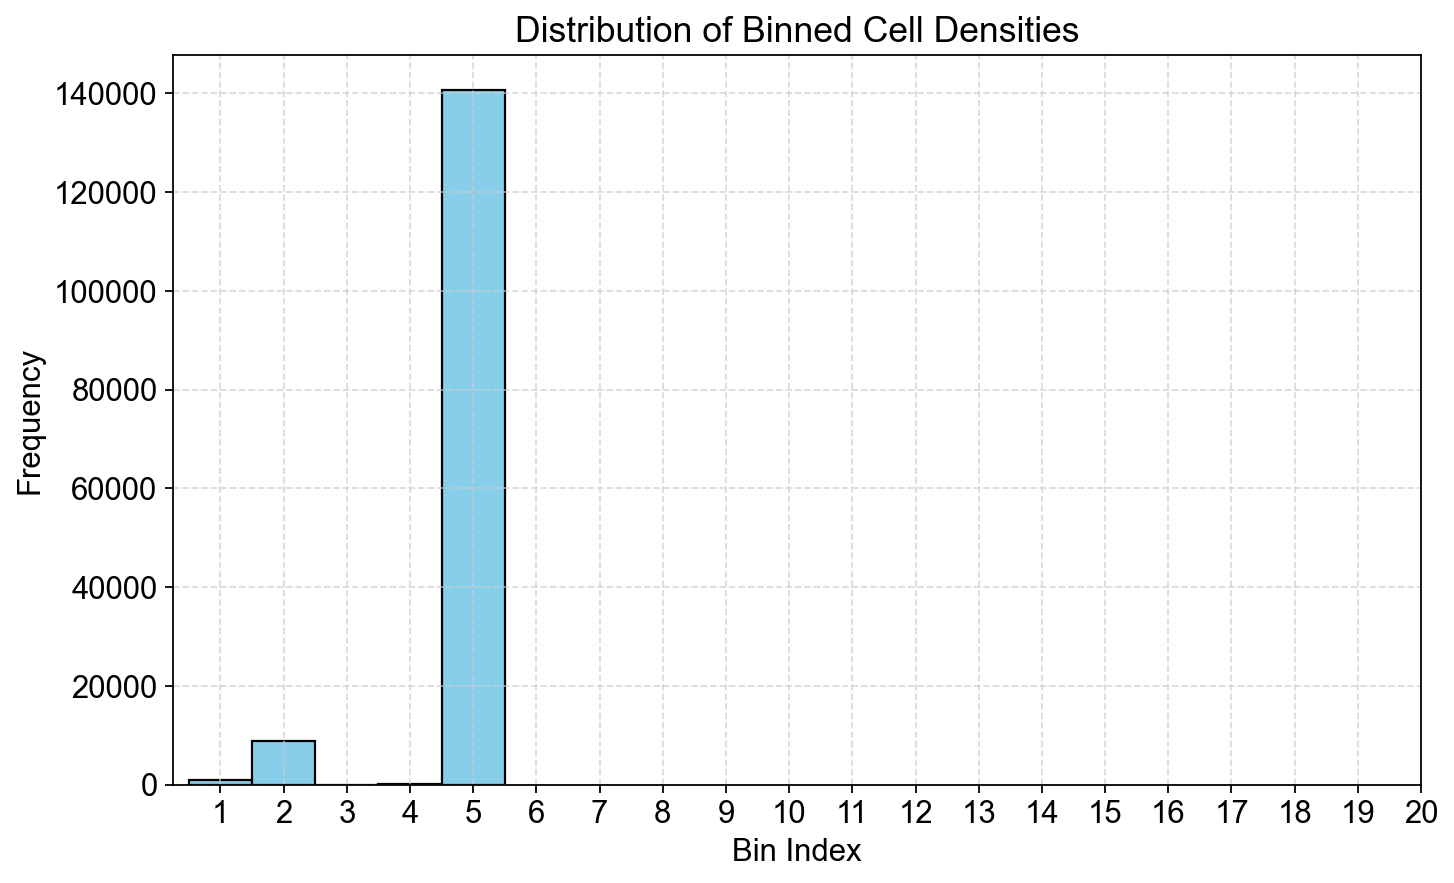

In [76]:
# Plotting the new binned cell densities
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=np.arange(1, len(np.unique(predictions))) - 0.5, edgecolor='black', color='skyblue')
plt.title("Distribution of Binned Cell Densities", fontsize=16)
plt.xlabel("Bin Index", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(range(1, 21))  # Ensure x-ticks align with bin indices
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

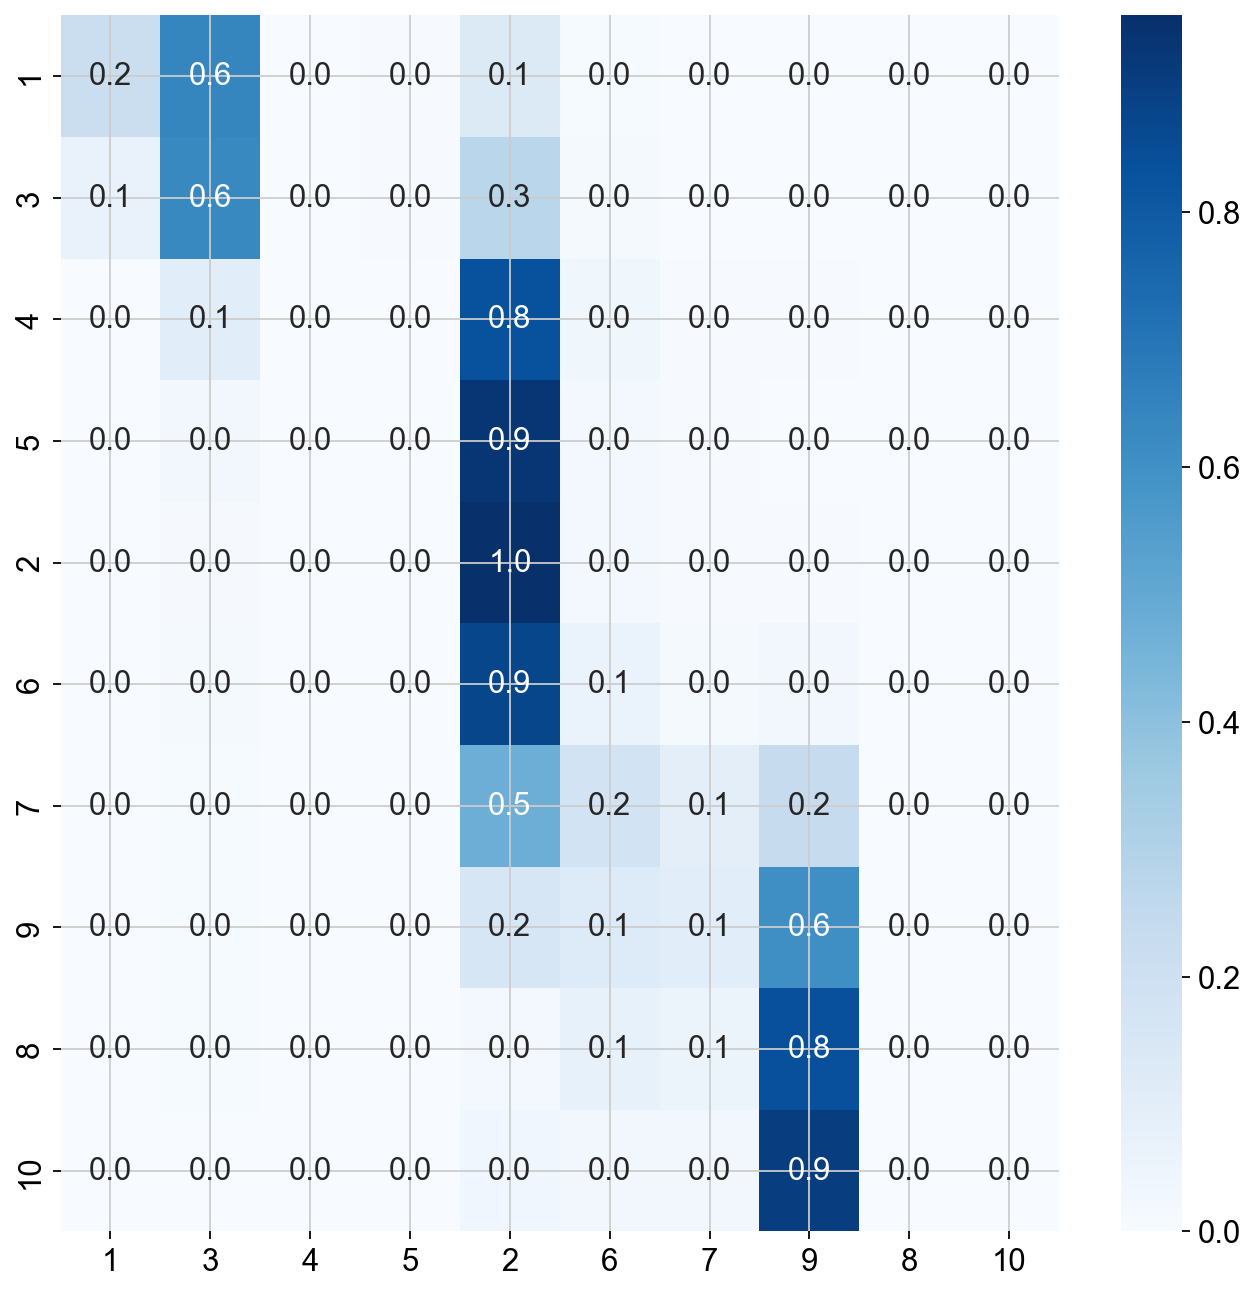

In [75]:
from sklearn.metrics import confusion_matrix
celltypes = list(celltypes)
for i in set([id2type[p-1] for p in predictions]):
    if i not in celltypes:
        celltypes.remove(i)
cm = confusion_matrix(labels, predictions)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=celltypes[:cm.shape[0]], columns=celltypes[:cm.shape[1]])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")
plt.savefig(save_dir / "confusion_matrix.png", dpi=300)

results["test/confusion_matrix"] = wandb.Image(
    str(save_dir / "confusion_matrix.png"),
    caption=f"confusion matrix",
)

In [34]:
# save the model into the save_dir
torch.save(best_model.state_dict(), save_dir / "model.pt")